In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random

In [2]:
#!pip install matplotlib

## Simulate Trails
Below creates 10,000 trails to simulate running these strategies. For this simulated data we have a fixed conversion rate specifed below for each. In the real world this would be sourced via actual experiments either live or from focus groups. 

In [3]:
N = 10_000 # Rounds
d = 9

# Creating the simulation
conversion_rates = [0.05,0.13,0.09,0.16,0.11,0.04,0.20,0.08,0.01]
X = np.array(np.zeros([N,d]))

# For each round, randomly generate probability that user converts, 
# if below stratergy conversion rate record as conversion
for i in range(N):
    for j in range(d):
        if np.random.rand() <= conversion_rates[j]:
            X[i,j] = 1

## Hypothesis Test

### H0: Random Strategy 
The null hypothesis is that randomly selecting a strategy each trail will result in finding the most profitable strategy with the maxium ROI (reward - cost)

### HA: Thompson Sampling
The alternative hypothesis is that thompson sampling each trail will result in finding the most profitable strategy and yeild the hieghest ROI

In [4]:
# Plot 9 Beta distribution, each representing either a progression in success of failures

def beta_dist(alpha, beta):
    c = 1 / ((math.factorial(alpha) * math.factorial(beta)) / (math.factorial(alpha + beta)))
    p_sup = alpha - 1
    p_msup = beta - 1
    
    dist = []
    for x in np.arange(0, 1, step=0.001):
        dist.append(c * (x**p_sup) * ((1 - x)**p_msup))
        
    return np.array(dist)

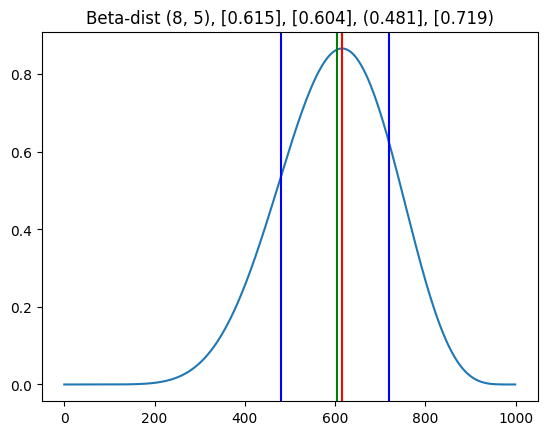

In [40]:
# Create standardised distribution (y [0, 1])
r_alpha = 8
r_beta = 5

dist = beta_dist(r_alpha+1, r_beta+1)
#dist = (dist - dist.min()) / (dist.max() - dist.min())
size = len(dist)
max_i = np.argmax(dist)
max_v = np.max(dist)

# lower 17.5% bound & upper 82.5% bound for the middle 65% of the distribution
lb_p = 0.175
ub_p = (1 - lb_p)
cum_dist = dist.cumsum()
map_dist = (cum_dist - cum_dist.min()) / (cum_dist.max() - cum_dist.min())

# Get stats
m_idx = np.where(map_dist <= 0.5)[0].max()
lb_idx = np.where(map_dist < lb_p)[0].max()
ub_idx = np.where(map_dist > ub_p)[0].min()


plt.plot(dist)
plt.title(f"Beta-dist ({r_alpha}, {r_beta}), [{max_i/1_000}], [{m_idx/1_000}], ({lb_idx/1_000}], [{ub_idx/1_000})") 

# only one line may be specified; full height
plt.axvline(x=lb_idx, color='b', label='lower_bound_65_percentile')
plt.axvline(x=ub_idx, color='b', label='upper_bound_65_percentile')

plt.axvline(x=m_idx, color='g', label=f"Mean value ({dist[m_idx]})")


plt.axvline(x=max_i, color='r', label=f"Max value ({max_v}, {max_i/1_000})")

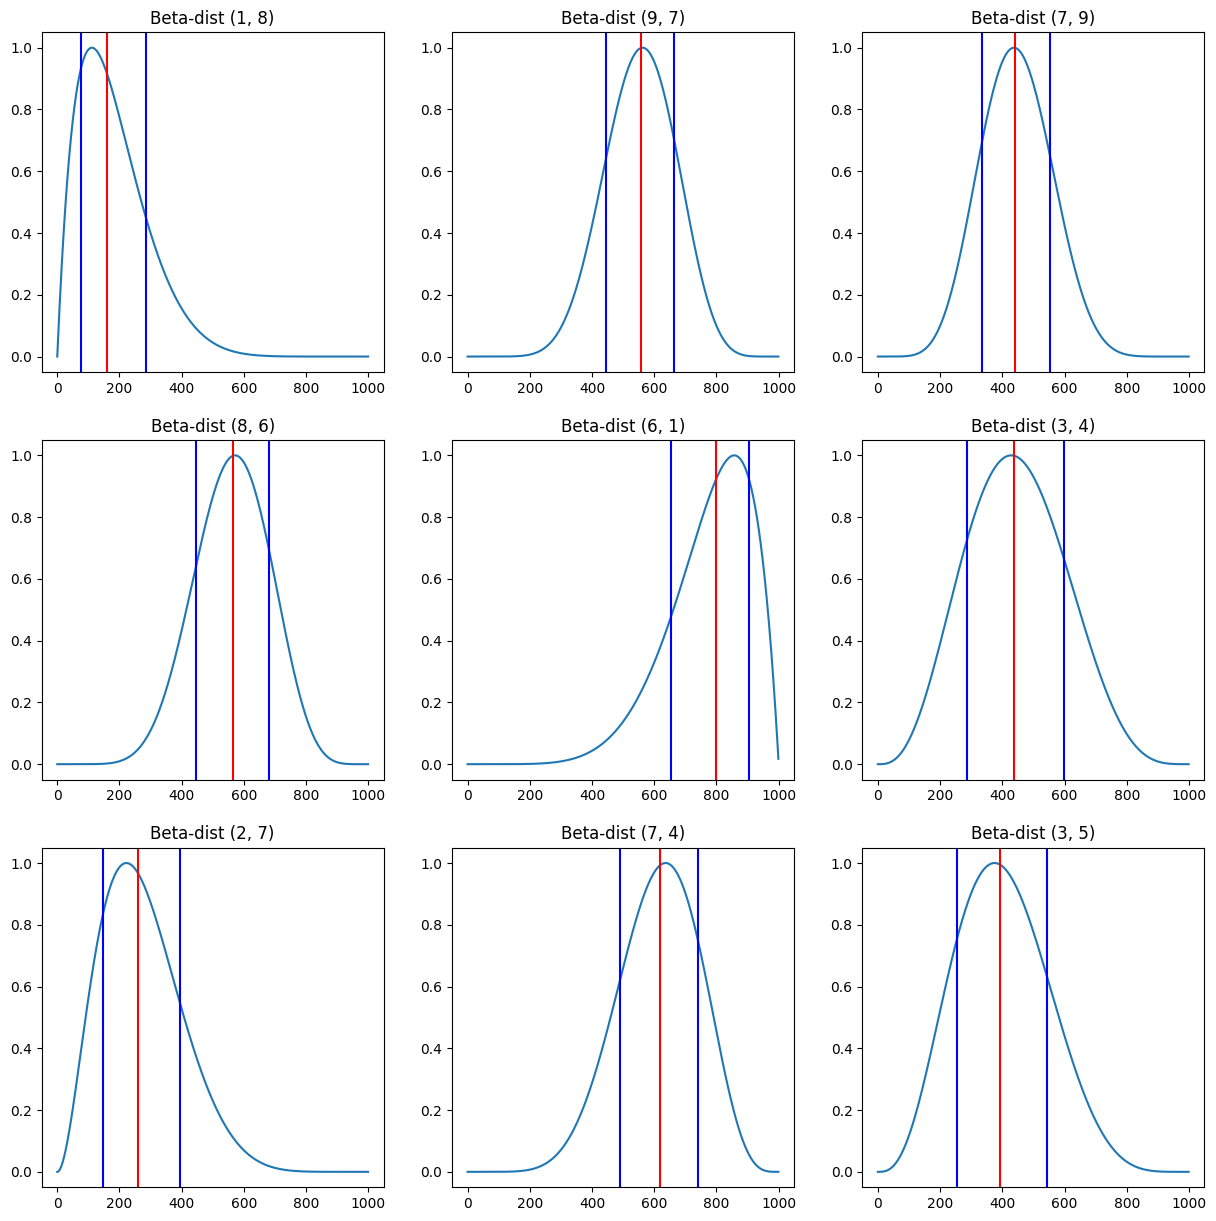

In [7]:

# Initialise the subplot function using number of rows and columns 
figure, axis = plt.subplots(3, 3, figsize=(15, 15)) 

for i in range(axis.shape[0]):
    for j in range(axis.shape[1]):
        r_alpha = np.random.randint(1, 10)
        r_beta = np.random.randint(1, 10)
        
        dist = beta_dist(r_alpha+1, r_beta+1)
        dist = (dist - dist.min()) / (dist.max() - dist.min())
        size = len(dist)
        max_v = np.argmax(dist)
        
        # lower & upper
        cum_dist = dist.cumsum()

        map_dist = (cum_dist - cum_dist.min()) / (cum_dist.max() - cum_dist.min())
        m_idx = np.where(map_dist <= 0.5)[0].max()
        lb_idx = np.where(map_dist < 0.175)[0].max()
        ub_idx = np.where(map_dist > (1 - 0.175))[0].min()

          
        # 
        axis[i, j].plot(dist) 
        axis[i, j].set_title(f"Beta-dist ({r_alpha}, {r_beta})") 
  

        # only one line may be specified; full height
        axis[i, j].axvline(x=lb_idx, color='b', label='lower_bound_65_percentile')
        axis[i, j].axvline(x=ub_idx, color='b', label='upper_bound_65_percentile')

        axis[i, j].axvline(x=m_idx, color='r', label=f"Mean value ({max_v})")


# Combine all the operations and display 
plt.show() 

# mid = int(size * dist_10_5.mean())
# plt.axvline(x=mid, color='r', label='axvline - full height')
# dist_10_5.sum()

In [8]:
strategies_selected_rs = []
strategies_selected_ts = []
total_reward_rs = 0
total_reward_ts = 0
total_roi_rs = 0
total_roi_ts = 0
numbers_of_rewards_1 = [0] * d
numbers_of_rewards_0 = [0] * d
numbers_of_rewards_1_rs = [0] * d
numbers_of_rewards_0_rs = [0] * d
cost = [10, 10, 11, 12, 13, 17, 15, 5, 9] # cost to run each strategy, each has different cost
reward = 52 # earning from a conversion, same regardless of strategy
rewards_strategies = [0] * d
regret = []

for n in range(0, N):
# n = 0
# while total_reward_rs == 0 or ((total_reward_ts - total_reward_rs) / total_reward_rs * 100 < 75 and n < N):
    strategy_rs = random.randrange(d)
    strategies_selected_rs.append(strategy_rs)
    reward_rs = X[n, strategy_rs]
    
    total_roi_rs -= cost[strategy_rs] # pay to play
    if reward_rs == 1:
        numbers_of_rewards_1_rs[strategy_rs] = numbers_of_rewards_1_rs[strategy_rs] + 1
        total_roi_rs += reward
    else:
        numbers_of_rewards_0_rs[strategy_rs] = numbers_of_rewards_0_rs[strategy_rs] + 1
    
    
    total_reward_rs += reward_rs
    # Best Strategy
    for i in range(0, d):
        rewards_strategies[i] = rewards_strategies[i] + X[n, i]
    total_reward_bs = max(rewards_strategies)
    # Regret
    regret.append(total_reward_bs - total_reward_rs)
    
    
    # Thompson Sampling
    strategy_ts = 0
    max_random = 0
    for i in range(0, d):
        # Beta distribution. Returns [0, 1] based on the number of success versus failures
        random_beta = random.betavariate(numbers_of_rewards_1[i] + 1, numbers_of_rewards_0[i] + 1)
        
        # Get best strategy based on the max beta value
        if random_beta > max_random:
            max_random = random_beta
            strategy_ts = i
    
    # record success & failures
    reward_ts = X[n, strategy_ts]
    
    total_roi_ts -= cost[strategy_ts] # pay to play
    if reward_ts == 1:
        numbers_of_rewards_1[strategy_ts] = numbers_of_rewards_1[strategy_ts] + 1
        total_roi_ts += reward
    else:
        numbers_of_rewards_0[strategy_ts] = numbers_of_rewards_0[strategy_ts] + 1
    
    strategies_selected_ts.append(strategy_ts)
    total_reward_ts += reward_ts
    #n += 1
    for i in range(0, d):
        rewards_strategies[i] = rewards_strategies[i] + X[n, i]
    total_reward_bs = max(rewards_strategies)
    # Regret
    regret.append(total_reward_bs - total_reward_ts)

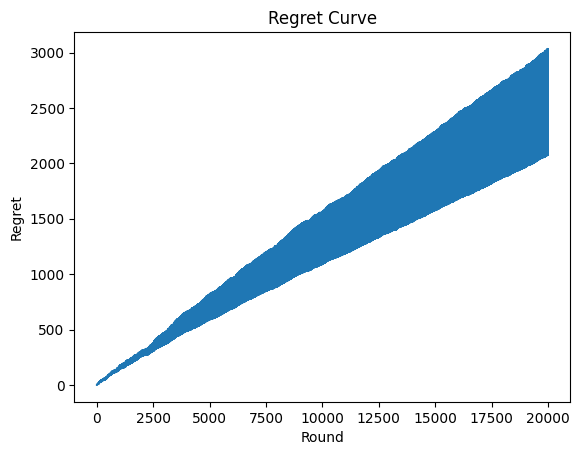

In [9]:
# Plotting the Regret Curve
plt.plot(regret)
plt.title('Regret Curve')
plt.xlabel('Round')
plt.ylabel('Regret')
plt.show()

In [10]:
# Computing the Relative Return
relative_return = (total_reward_ts - total_reward_rs) / total_reward_rs * 100
relative_return_roi = abs(total_roi_ts - total_roi_rs) / abs(total_roi_rs) * 100
print("Relative Return: {:.2f} %".format(relative_return))
print("Relative Return on ROI: {:.2f} %".format(relative_return_roi))
print(f"Number of trails: {n} ")

Relative Return: 98.04 %
Relative Return on ROI: 26.83 %
Number of trails: 9999 


In [11]:
print(f"Thompson Sampling ROI: ${total_roi_ts}")
print(f"Random Sampling ROI: ${total_roi_rs}")
print(f"Absolute ROI: ${abs(total_roi_rs - total_roi_ts):,.2f}")
print(f"Random Sampling ROI: ${total_roi_rs}")
print((abs(total_roi_ts - total_roi_rs)))


Thompson Sampling ROI: $-46139
Random Sampling ROI: $-63055
Absolute ROI: $16,916.00
Random Sampling ROI: $-63055
16916


In [12]:
strategies_selected_rs = []
strategies_selected_ts = []
total_reward_rs = 0
total_reward_ts = 0
total_roi_rs = 0
total_roi_ts = 0
numbers_of_rewards_1 = [0] * d
numbers_of_rewards_0 = [0] * d
numbers_of_rewards_1_rs = [0] * d
numbers_of_rewards_0_rs = [0] * d
cost = [10, 10, 11, 12, 13, 17, 9, 5, 9] # cost to run each strategy, each has different cost
reward = 52 # earning from a conversion, same regardless of strategy

rewards_strategies = [0] * d
regret = []
regret_roi = []
total_cost_bs = 0

rewards_strategies = [0] * d
regret_ts = []
regret_roi_ts = []
regret_rs = []
regret_roi_rs = []
total_cost_bs = 0

#for n in range(0, N):
n = 0
while total_reward_rs == 0 or (regret_ts[-1] <= 20 and n < N):
    strategy_rs = random.randrange(d)
    strategies_selected_rs.append(strategy_rs)
    reward_rs = X[n, strategy_rs]
    
    total_roi_rs -= cost[strategy_rs] # pay to play
    if reward_rs == 1:
        numbers_of_rewards_1_rs[strategy_rs] = numbers_of_rewards_1_rs[strategy_rs] + 1
        total_roi_rs += reward
    else:
        numbers_of_rewards_0_rs[strategy_rs] = numbers_of_rewards_0_rs[strategy_rs] + 1
    
    
    total_reward_rs += reward_rs
    
    # Best strategy
    for i in range(0, d):
        rewards_strategies[i] = rewards_strategies[i] + X[n, i]
    total_reward_bs = max(rewards_strategies)
    
    bs_idx = np.argmax(X[n, i])
    bs_cost = reward - cost[bs_idx]
    total_cost_bs += bs_cost
    
    
    # Regret
    regret_rs.append(total_reward_bs - total_reward_rs)
    regret_roi_rs.append(total_cost_bs - total_roi_rs)
    
    # Thompson Sampling
    strategy_ts = 0
    max_random = 0
    for i in range(0, d):
        # Beta distribution. Returns [0, 1] based on the number of success versus failures
        random_beta = random.betavariate(numbers_of_rewards_1[i] + 1, numbers_of_rewards_0[i] + 1)
        
        # Get best strategy based on the max beta value
        if random_beta > max_random:
            max_random = random_beta
            strategy_ts = i
    
    # record success & failures
    reward_ts = X[n, strategy_ts]
    
    total_roi_ts -= cost[strategy_ts] # pay to play
    if reward_ts == 1:
        numbers_of_rewards_1[strategy_ts] = numbers_of_rewards_1[strategy_ts] + 1
        total_roi_ts += reward
    else:
        numbers_of_rewards_0[strategy_ts] = numbers_of_rewards_0[strategy_ts] + 1
    
    strategies_selected_ts.append(strategy_ts)
    total_reward_ts += reward_ts
    n += 1
    
    
    # Regret, compare the total possible earnings vs the earning with thompson sampling
    regret_ts.append(total_reward_bs - total_reward_ts)
    regret_roi_ts.append(total_cost_bs - total_roi_ts)

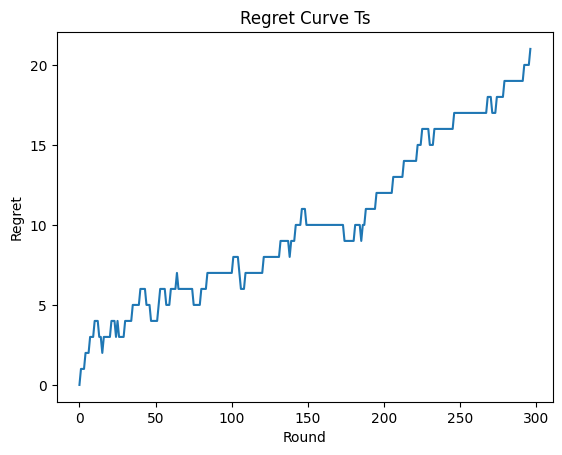

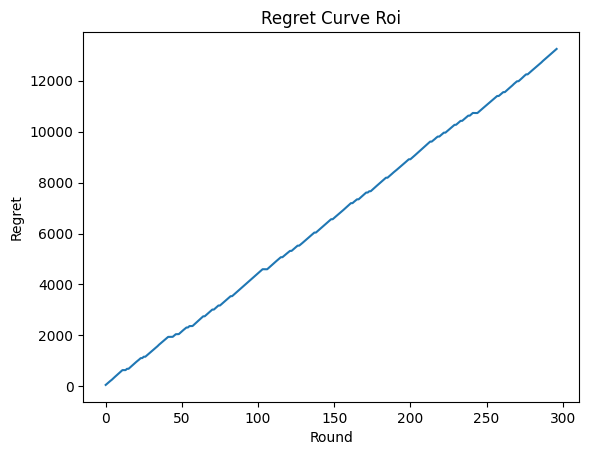

In [13]:
# Plotting the Regret Curve
plt.plot(regret_ts)
plt.title('Regret Curve Ts')
plt.xlabel('Round')
plt.ylabel('Regret')
plt.show()
plt.plot(regret_roi_ts)
plt.title('Regret Curve Roi')
plt.xlabel('Round')
plt.ylabel('Regret')
plt.show()

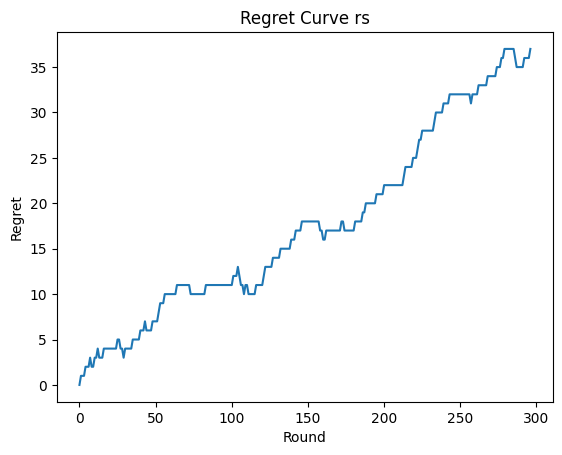

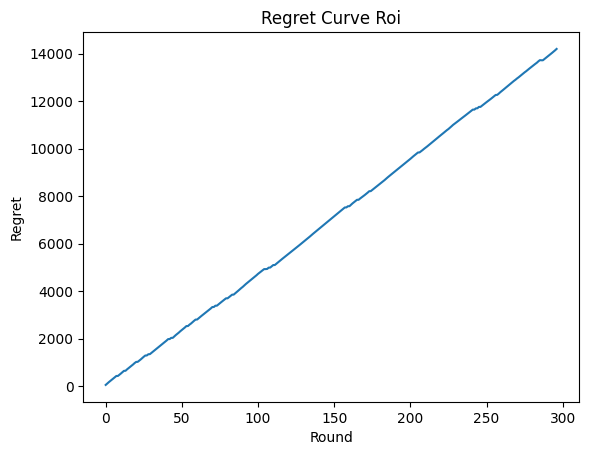

In [14]:
# Plotting the Regret Curve
plt.plot(regret_rs)
plt.title('Regret Curve rs')
plt.xlabel('Round')
plt.ylabel('Regret')
plt.show()
plt.plot(regret_roi_rs)
plt.title('Regret Curve Roi')
plt.xlabel('Round')
plt.ylabel('Regret')
plt.show()

In [ ]:
# Computing the Relative Return
relative_return = (total_reward_ts - total_reward_rs) / total_reward_rs * 100
relative_return_roi = abs(total_roi_ts - total_roi_rs) / abs(total_roi_rs) * 100
print("Relative Return: {:.2f} %".format(relative_return))
print("Relative Return on ROI: {:.2f} %".format(relative_return_roi))
print(f"Number of trails: {n} ")

In [ ]:
print(f"Thompson Sampling ROI: ${total_roi_ts}")
print(f"Random Sampling ROI: ${total_roi_rs}")
print(f"Absolute ROI: ${abs(total_roi_rs - total_roi_ts):,.2f}")
print(f"Random Sampling ROI: ${total_roi_rs}")
print((abs(total_roi_ts - total_roi_rs)))


In [ ]:
ts_conversions = (np.array(numbers_of_rewards_1) / (np.array(numbers_of_rewards_1) + np.array(numbers_of_rewards_0))).round(2).tolist()
ts_conversions

In [ ]:
# Initialise the subplot function using number of rows and columns 
figure, axis = plt.subplots(3, 3, figsize=(15, 15)) 

for i in range(axis.shape[0]):
    for j in range(axis.shape[1]):
        r_alpha = numbers_of_rewards_1[(i*3)+j]
        r_beta = numbers_of_rewards_0[(i*3)+j]
        
        if (ts_conversions[(i*3)+j] == 0):
            axis[i, j].set_title(f"Beta-dist ({r_alpha}, {r_beta})") 
            continue
        
        dist = beta_dist(r_alpha+1, r_beta+1)
        dist = (dist - dist.min()) / (dist.max() - dist.min())
        size = len(dist)
        max_v = np.argmax(dist)
        
        # lower & upper
        cum_dist = dist.cumsum()

        map_dist = (cum_dist - cum_dist.min()) / (cum_dist.max() - cum_dist.min())
        m_idx = np.where(map_dist <= 0.5)[0].max()
        lb_idx = np.where(map_dist < 0.175)[0].max()
        ub_idx = np.where(map_dist > (1 - 0.175))[0].min()

          
        # 
        axis[i, j].plot(dist) 
        axis[i, j].set_title(f"Beta-dist ({r_alpha}, {r_beta})") 
  

        # only one line may be specified; full height
        axis[i, j].axvline(x=lb_idx, color='b', label='lower_bound_65_percentile')
        axis[i, j].axvline(x=ub_idx, color='b', label='upper_bound_65_percentile')

        axis[i, j].axvline(x=m_idx, color='r', label=f"Mean value ({max_v})")


# Combine all the operations and display 
plt.show() 

In [ ]:
print(total_roi_ts)
print(total_roi_rs)
print((abs(total_roi_ts - total_roi_rs)))
print((abs(total_roi_ts - total_roi_rs)) / abs(total_roi_rs))

total_roi_rs + total_roi_ts

In [ ]:
# Plotting the Histogram of Selections
plt.hist((np.array(strategies_selected_ts) + 1).tolist())
plt.title('Histogram of Selections')
plt.xlabel('Strategy')
plt.ylabel('Number of times the strategy was selected')
plt.show()

In [ ]:
test = []

for i, x in enumerate(numbers_of_rewards_1):
    count = [i] * x
    if len(count) > 0:
        test = [*test, *count]

In [ ]:
# Plotting the Histogram of Selections
plt.hist(test)
plt.title('Histogram of Number of Rewards')
plt.xlabel('Strategy')
plt.ylabel('Number of times the strategy converted')
plt.show()

In [ ]:
X.sum(axis=0).astype(int).tolist()
test2 = []

for i, x in enumerate(X.sum(axis=0).astype(int).tolist()):
    count = [i] * x
    if len(count) > 0:
        test2 = [*test2, *count]

In [ ]:
plt.hist(test2)
plt.title('Histogram of Number of Rewards')
plt.xlabel('Strategy')
plt.ylabel('Number of times the strategy converted')
plt.show()

In [ ]:
test3 = []

for i, x in enumerate(numbers_of_rewards_1_rs):
    count = [i] * x
    if len(count) > 0:
        test3 = [*test3, *count]

In [ ]:
plt.hist(test3)
plt.title('Histogram of Number of Rewards (random)')
plt.xlabel('Strategy')
plt.ylabel('Number of times the strategy converted')
plt.show()

In [ ]:
ts_conversions = (np.array(numbers_of_rewards_1) / (np.array(numbers_of_rewards_1) + np.array(numbers_of_rewards_0))).round(2).tolist()
#print(ts_conversions)
cost = 10
reward = 52


(np.array(numbers_of_rewards_1) * reward).sum() - ((np.array(numbers_of_rewards_1) + np.array(numbers_of_rewards_0)) * cost).sum()


In [ ]:
[0.05,0.13,0.09,0.16,0.11,0.04,0.20,0.08,0.01]


In [ ]:
rs_conversions = (np.array(numbers_of_rewards_1_rs) / (np.array(numbers_of_rewards_1_rs) + np.array(numbers_of_rewards_0_rs))).round(2).tolist()
rs_conversions


(np.array(numbers_of_rewards_1_rs) * reward).sum() - ((np.array(numbers_of_rewards_1_rs) + np.array(numbers_of_rewards_0_rs)) * cost).sum()


In [ ]:
# Get count occurrence of all values
from collections import Counter
count = Counter(strategies_selected_ts)
count

In [ ]:
count = Counter(strategies_selected_rs)
count